Prashant P. Singh - 8448315

Lets start with statistical models for the task at hand. One can look at this problem, where words are features and we are trying to predict the target class. However as the models cannot directly work with words we need to encode these words and build some more features using the same and then use those to predict the models. As mentioned below we will be trying with representative from each borad categories (Regression, Ensemble methods, kernel methods and Boosted trees) 

In [1]:
# Lets mount the Google Drive and acccess the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Function to load the data from the folder in Google Drive

def load_data():
  import pickle
  path = '/content/drive/MyDrive/IMDB'  # path to the folder in google drive where data is saved
  with open(path + "/train.pkl", 'rb') as a, open(path + "/test.pkl", 'rb') as b:
      d_train = pickle.load(a)   # loading training data
      d_test = pickle.load(b)   # loading test data 
  return d_train, d_test

# loading data set
d_train, d_test = load_data()

In [3]:
# Its always good practice to keep validation set separately apart from test, in case we need to do grid search or hyperparameter tuning
# we cannot use the test for these and also this keeps check on VC-dimentionality issue.

# further as it is not clear if the test set should be used for validation or final test only however given IMDB dataset 
# is very stnadard dataset and the benchmarking is done by using the 25k whole test data set , 
# therefore to conform with the benchmark standard we will use test only for final test.

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(d_train.text, d_train.label, train_size=0.8)
X_test, y_test = d_test.text,d_test.label

1. Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc.: the rank-frequency distribution is an inverse relation.
2. Tf_IDF: The absic idea is words which are generally frequent in documents are less informative, than the ones that are generally rare, but frequent in a small subset of documents. Therefore it makes sense to make the  rare words common in a subset of the document more prominent and effectively ignore common words.
3. What about stop words and common words:
*   One can argue that in case of LSTM and Sequence modelling these can play important role but in case of statistical tools like 'Random Forest' etc they cannot add value and hence should be removed.
*   When we look at the comment 2, it is obvious that while using Tf-IDF we can ignore the removal of stop words or common words like " 'a', 'the', 'and','of' etc" as Tf-idf can take care of this automatically by assignning them low value.
*   Further removal of stop words had always been controversial, as highlighted by this [paper](https://ieeexplore.ieee.org/document/7375527), the better accuracy was acheived without removing stop words, so lets go with wisdom.


In [1]:
# lets now lemmatize the text
# we will use Wordnet for the same

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_text(texts):
  lemmatizer = WordNetLemmatizer()
  return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in texts]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ppsin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from sklearn.model_selection import train_test_split

# we will create the validation set from train
X_train, X_val, y_train, y_val = train_test_split(d_train.text, d_train.label, train_size=0.8)
X_test, y_test = d_test.text,d_test.label

train_reviews = lemmatize_text(X_train)
val_reviews = lemmatize_text(X_val)
test_reviews = lemmatize_text(X_test)

In [ ]:
# lets see how much the data is balanced/imbalanced
print("Labels count in train \n",y_train.value_counts())
print("labels count in test \n", y_test.value_counts())

Labels count in train 
 1    10000
0    10000
Name: label, dtype: int64
labels count in test 
 1    12500
0    12500
Name: label, dtype: int64


We give the n_grams range to be 2, this will create unigrams (i.e tokens) and bi-grams.
Why? 
Ex: 'very bad' and 'very good', in this if we use unigrams then very cannot imply positive or negative sentiment but with 'good' or 'bad' only it can. While model can build such relationship ebtween feature but by passing such explicit feature can improve the models performance.


In [35]:
%%time
# lets implement TF_idf, we will use ngrams = 1,2

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf  = TfidfVectorizer(ngram_range=(1, 2)).fit(train_reviews)  # fit on the train
dfx = tfidf.transform(train_reviews)    # transform the train
dfxval = tfidf.transform(val_reviews)   # transform the val using same object/model
dfxtest = tfidf.transform(test_reviews) # transform the test using same object/model


CPU times: user 46.9 s, sys: 492 ms, total: 47.4 s
Wall time: 47.7 s


In [ ]:
%%time

# as can be seen we have the balanced dataset so we can use the accuracy metric

from sklearn.linear_model import LogisticRegression   # use this for benchmark
from sklearn.svm import SVC                           # considered as top of its class in kernel methods
from sklearn.ensemble import RandomForestClassifier   # ensemble method participant
from sklearn.ensemble import GradientBoostingClassifier # Tress combined with power of Gradient descent

# those are sufficient enough number of models
# we will be using accuracy metric
from sklearn.metrics import accuracy_score
import pandas as pd

models = []
models.append(('Logistic', LogisticRegression()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('GradientBoostedTrees', GradientBoostingClassifier()))
models.append(('SVM', SVC()))

# dataframe for book keeping
report = pd.DataFrame(columns = ['model','Train_Accuracy','Val_Accuracy']) 


for name,model in models:
  model.fit(dfx, y_train)
  y_train_predict = model.predict(dfx)
  y_val_predict = model.predict(dfxval)
  train_accuracy = accuracy_score(y_train,y_train_predict)
  val_accuracy = accuracy_score(y_val, y_val_predict)
  report.loc[len(report)] = [name,train_accuracy,val_accuracy]
  print("Accuracy on valid for {}: {}".format(name,val_accuracy))


Accuracy on valid for Logistic: 0.8858
Accuracy on valid for RandomForest: 0.842
Accuracy on valid for GradientBoostedTrees: 0.806
Accuracy on valid for SVM: 0.8948
CPU times: user 1h 14min 47s, sys: 20.4 s, total: 1h 15min 8s
Wall time: 1h 14min 27s


In [ ]:
path = '/content/drive/MyDrive/IMDB/'
report.to_csv(path + 'statisticalmodel.csv')

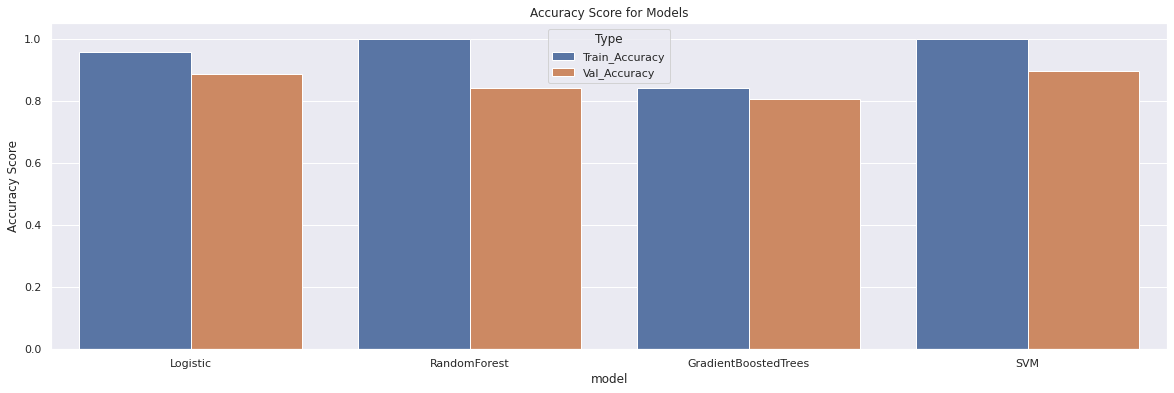

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def model_plot(report):
  # Reshaping dataframe in  way to make it compatible to pass it to seaborn
  df = pd.melt(report, id_vars="model", var_name="Type", value_name="Accuracy Score")
  
  # some fancy thing to make plots nice, you can different palette types and style
  # https://seaborn.pydata.org/tutorial/color_palettes.html
  
  sns.set_palette("pastel")
  sns.set(style="darkgrid")
  fig, ax = plt.subplots( figsize=(20,6))
  a = sns.barplot(data=df, x="model", y= 'Accuracy Score', hue="Type", ax = ax)
  a.set_title('Accuracy Score for Models')
  # show_values_on_bars(ax1, "v", 0.5)
  fig.savefig(path +"Accuracy_plotfor_stat"+ '.png')

model_plot(report)

As can be seen that gradientboosted trees are behind, we will keep the SVC, RandomForest and Logistic for further analysis. Logistic regression will be kept for base becnhmarking. 

 ### Gridsearch vs Randomized gridsearch

*   The ideal way of doing paramteric search is to start with Randomized grid search where you can pass params list but instead of trying everything we 'eyeball' the space to get an idea where to do the fine search. In radomized grid search it is good to pass extreme values and make big jumps in values of params (we are eyeballing the topology)

*   Once we narrow down on the space of param we can try fine tuning combinations of params with small increments (in case of ordinal)

In [ ]:
%%time
def random_grid():
  from sklearn.linear_model import LogisticRegression   # use this for benchmark
  from sklearn.svm import SVC                           # considered as top of its class in kernel methods
  from sklearn.ensemble import RandomForestClassifier   # ensemble method participant 
  from sklearn.model_selection  import RandomizedSearchCV
  import pandas as pd

  path = '/content/drive/MyDrive/IMDB/'

  X_train, y_train = d_train.text,d_train.label

  # tokenize the training set
  from sklearn.feature_extraction.text import TfidfVectorizer
  train_reviews = lemmatize_text(X_train)
  tfidf  = TfidfVectorizer(ngram_range=(1, 2)).fit(train_reviews)  # fit on the train
  dfx = tfidf.transform(train_reviews)    # transform the train
 

  rf = RandomForestClassifier(random_state =7)
  rf_param = {'n_estimators': [100,200,300,400,500],  # number of trees, very low value can create bias
              'max_depth': [5,10,50,100,None],        # max_depth of tree, very high values leads to overfitting
              'max_features': ['auto', 'log2'],       # feature selections for split
              'criterion': ['gini', 'entropy'] }      # criteren to make the splitting 

# total combinations are 100, whcih will take lot fo time instead using Randomizedsearch we can get quickly get answers
# n_iters = 15, total combination which will be tried
  grid_rf = RandomizedSearchCV(rf, rf_param, n_iter=15, cv= 2,random_state=7, verbose = 2)
  grid_rf.fit(dfx, y_train)
  print("Best Param of Random Forest: ",grid_rf.best_params_)
  print("Best Score: ",grid_rf.cv_results_)

  # book keeping for params and results
  df  = pd.concat([pd.DataFrame(grid_rf.cv_results_["params"]),pd.DataFrame(grid_rf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
  df.to_csv(path + "RF_grid.csv")

  # running grid for SVC, more on paramters below
  svc_rbf = SVC(random_state =7)
  svc_param = {'C': [0.02,0.5,1,5]}   # Regularization parameter. The strength of the regularization is inversely proportional to C.
  grid_svc = RandomizedSearchCV(svc_rbf, svc_param, n_iter=4, cv= 2,random_state=7, verbose = 2)
  grid_svc.fit(dfx, y_train)
  print("Best Param of Random Forest: ",grid_svc.best_params_)
  print("Best Score: ",grid_svc.cv_results_)
  df  = pd.concat([pd.DataFrame(grid_svc.cv_results_["params"]),pd.DataFrame(grid_svc.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
  df.to_csv(path + "SVC_grid.csv")

random_grid()

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV] END criterion=gini, max_depth=100, max_features=log2, n_estimators=300; total time= 1.1min
[CV] END criterion=gini, max_depth=100, max_features=log2, n_estimators=300; total time= 1.1min
[CV] END criterion=gini, max_depth=50, max_features=log2, n_estimators=200; total time=  31.1s
[CV] END criterion=gini, max_depth=50, max_features=log2, n_estimators=200; total time=  30.7s
[CV] END criterion=entropy, max_depth=50, max_features=log2, n_estimators=400; total time=  52.4s
[CV] END criterion=entropy, max_depth=50, max_features=log2, n_estimators=400; total time=  48.2s
[CV] END criterion=entropy, max_depth=None, max_features=auto, n_estimators=200; total time= 8.0min
[CV] END criterion=entropy, max_depth=None, max_features=auto, n_estimators=200; total time= 7.7min
[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=500; total time=14.5min
[CV] END criterion=gini, max_depth=None, max_features=log2, n_es

In [ ]:
# Due to timeout issue of Google colab, we ran the SVC grid search on local machine the results of 
# which are present below as screenshot and also the csv file is provided in folder.
from sklearn.linear_model import LogisticRegression   # use this for benchmark
from sklearn.svm import SVC                           # considered as top of its class in kernel methods
from sklearn.ensemble import RandomForestClassifier   # ensemble method participant 
from sklearn.model_selection  import RandomizedSearchCV
import pandas as pd

X_train, y_train = d_train.text,d_train.label  # reading training data set

# tokenize the training set
from sklearn.feature_extraction.text import TfidfVectorizer
train_reviews = lemmatize_text(X_train)
tfidf  = TfidfVectorizer(ngram_range=(1, 2)).fit(train_reviews)  # fit on the train
dfx = tfidf.transform(train_reviews)    # transform the train

svc_rbf = SVC(random_state =7)

# C: Regularization parameter. The strength of the regularization is inversely proportional to C. C makes a trade 
# off between smooth boundary more points accuracte classification (by coming up with non smooth boundaries)
# gamma: kernel coefficients. It affects the decision boundary, lower the value farther the effect and vice versa.
# gamma and C affect the model in bias -variance tradeoff therefore 
# combination of them needs to tried out. Usually lower value of gamma reduce the 
svc_param = {'C': [0.05,0.5,5,10], 'gamma':['scale',0.005,0.05,0.5,1,2]}
grid_svc = RandomizedSearchCV(svc_rbf, svc_param, n_iter=10, cv= 2,random_state=7, verbose = 2)
grid_svc.fit(dfx, y_train)
print("Best Param of SVM: ",grid_svc.best_params_)
print("Best Score: ",grid_svc.cv_results_)

# book keeping for params and results
df  = pd.concat([pd.DataFrame(grid_svc.cv_results_["params"]),pd.DataFrame(grid_svc.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
df.to_csv("SVC_grid.csv")

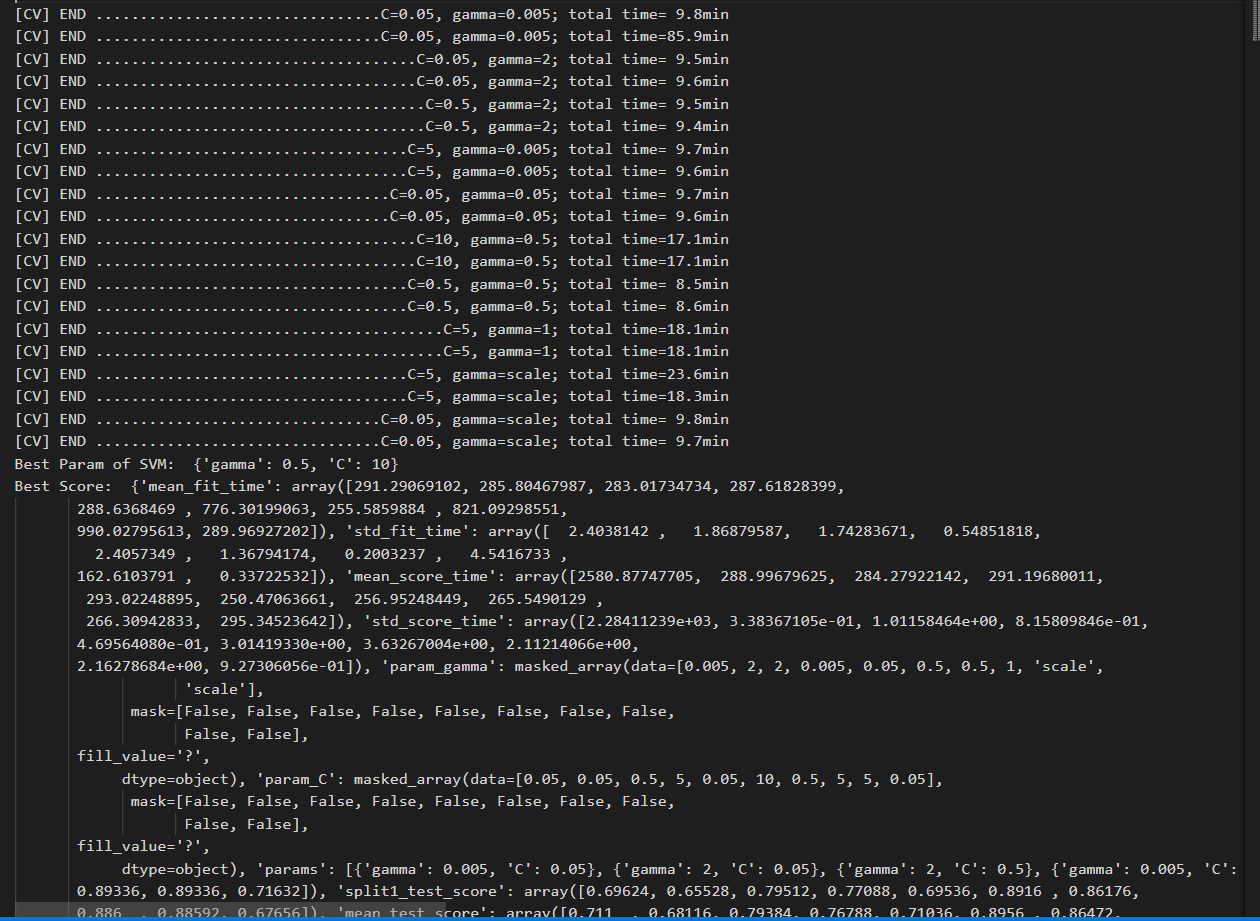

In [31]:
import pandas as pd
path = '/content/drive/MyDrive/IMDB/'

rf_grid = pd.read_csv(path + 'RF_grid.csv').drop(['Unnamed: 0'],axis=1)
svc_grid = pd.read_csv(path + 'SVC_grid.csv').drop(['Unnamed: 0'],axis=1)

# grid with gamma fixed as 'scale'
temp = pd.read_csv(path + 'SVC_grid_gamma.csv').drop(['Unnamed: 0'],axis=1)
temp['gamma'] = 'scale'
svc_grid = pd.concat([svc_grid,temp])

In [32]:
# results os RandomForest Random Grid search
rf_grid.sort_values(by = ['Accuracy'], ascending= False)

,n_estimators,max_features,max_depth,criterion,Accuracy
4,500,log2,NaN,gini,0.85812
6,400,auto,NaN,entropy,0.85504
9,300,auto,50.0,gini,0.85356
3,200,auto,NaN,entropy,0.85236
7,200,auto,50.0,entropy,0.85228
10,400,auto,10.0,gini,0.84120
11,100,auto,NaN,gini,0.83844
13,300,auto,10.0,gini,0.83572
12,300,auto,5.0,entropy,0.82448
14,400,log2,100.0,entropy,0.80784


In case of Random forest it is seen that higher estimators values gives better results (intutively biggert eh forest better the ensembling 'Wisdom of many'). But as cen be seen from the graphs above R.reaches the 100% accuracy of train, so maybe it could be overfitting (not necessarily until we know validation and trianing is diverging) hence better to regularize this. In random forest one way to do this is to control for depth. By default RF imlementation goes on to build the trees with highest purity in leaf, which we can restrict by putting limit to the max-depth. Therefore we we will be going forward with Higher estimator values of [400,450,500] and max-depth of [50,60,70,100] with feature = [auto].


Grid Search for Random forest

In [38]:
%%time
from sklearn.linear_model import LogisticRegression   # use this for benchmark
from sklearn.svm import SVC                           # considered as top of its class in kernel methods
from sklearn.ensemble import RandomForestClassifier   # ensemble method participant 
from sklearn.model_selection  import GridSearchCV
import pandas as pd

X_train, y_train = d_train.text,d_train.label

# tokenize the training set
from sklearn.feature_extraction.text import TfidfVectorizer
train_reviews = lemmatize_text(X_train)
tfidf  = TfidfVectorizer(ngram_range=(1, 2)).fit(train_reviews)  # fit on the train
dfx = tfidf.transform(train_reviews)    # transform the train

# only n_estimator and max_depth need to tuned, as can be seen from the results above, critereon: gini and max_fatures: auto
# seemed to perform better, we can keep them fixed now.
rf = RandomForestClassifier(random_state =7)
rf_param = {'n_estimators': [400,450,500], 
            'max_depth': [50,60,70,100],
            'max_features': ['auto'],
            'criterion': ['gini'] }

# we will run Gridsearch instead of Randomizedgrid now
grid_rf = GridSearchCV(rf, rf_param,cv= 2, verbose = 2)
grid_rf.fit(dfx, y_train)
print("Best Param of Random Forest: ",grid_rf.best_params_)
print("Best Score: ",grid_rf.cv_results_)
df  = pd.concat([pd.DataFrame(grid_rf.cv_results_["params"]),pd.DataFrame(grid_rf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
df.to_csv(path + "RF_gridsearch.csv")

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] END criterion=gini, max_depth=50, max_features=auto, n_estimators=400; total time= 6.1min
[CV] END criterion=gini, max_depth=50, max_features=auto, n_estimators=400; total time= 6.0min
[CV] END criterion=gini, max_depth=50, max_features=auto, n_estimators=450; total time= 6.6min
[CV] END criterion=gini, max_depth=50, max_features=auto, n_estimators=450; total time= 6.9min
[CV] END criterion=gini, max_depth=50, max_features=auto, n_estimators=500; total time= 7.8min
[CV] END criterion=gini, max_depth=50, max_features=auto, n_estimators=500; total time= 7.4min
[CV] END criterion=gini, max_depth=60, max_features=auto, n_estimators=400; total time= 7.6min
[CV] END criterion=gini, max_depth=60, max_features=auto, n_estimators=400; total time= 7.0min
[CV] END criterion=gini, max_depth=60, max_features=auto, n_estimators=450; total time= 7.1min
[CV] END criterion=gini, max_depth=60, max_features=auto, n_estimators=450; total ti

In [39]:
# print the dataframe
# as can be seen best result are from n_estimator 500 (this was highest value we had, so there is 
# scope to go further than this), max_depth= 60
df

,criterion,max_depth,max_features,n_estimators,Accuracy
0,gini,50,auto,400,0.85520
1,gini,50,auto,450,0.85692
2,gini,50,auto,500,0.85760
3,gini,60,auto,400,0.85748
4,gini,60,auto,450,0.85752
5,gini,60,auto,500,0.85800
6,gini,70,auto,400,0.85620
7,gini,70,auto,450,0.85592
8,gini,70,auto,500,0.85760
9,gini,100,auto,400,0.85512


In [34]:
# results of SVC on Random Grid search
svc_grid.sort_values(by = ['Accuracy'], ascending= False)

,gamma,C,Accuracy
5,0.5,10.00,0.89560
7,1,5.00,0.88968
8,scale,5.00,0.88964
3,scale,5.00,0.88964
2,scale,1.00,0.88360
6,0.5,0.50,0.86472
1,scale,0.50,0.85880
2,2,0.50,0.79384
3,0.005,5.00,0.76788
0,0.005,0.05,0.71100


#### For the SVC it is seen that the higher value of C is warranted for different values of gamma. But as we know higher 'value' of C means less regularization and since we have seen in initial run that SVC is overtting (train accuracy ~ 100 %), hence lets go with C = 5.  Further it is noteworthy that Radial Gaussian Kernel finds the support vector in infinite dimension. While the radial gaussian function cause of its nature makes the influence of nearest neighbours more prominent than the one farther away, gamma (Ƴ) scales the influence, lets keep the gamma low that is  = 0.5.

In [2]:
import pickle
path = '/content/drive/MyDrive/IMDB/'  # path to the folder in google drive where data is saved
with open("train.pkl", 'rb') as a, open("test.pkl", 'rb') as b:
    d_train = pickle.load(a)   # loading training data
    d_test = pickle.load(b)   # loading test data 

In [10]:
# function to include the final models we will keep in the final run
def get_models():
    from sklearn.linear_model import LogisticRegression   # use this for benchmark
    from sklearn.svm import SVC                           # considered as top of its class in kernel methods
    from sklearn.ensemble import RandomForestClassifier   # ensemble method participant 
    from sklearn.model_selection  import RandomizedSearchCV
    import pandas as pd
    random_state = 7
    models=dict()
    models['Logistic'] = LogisticRegression()

    # running gridsearch on SVC is computationally expensive, however as we can see higher value of C and lower value of gamma is warranted
    # we will try the model with two different values of gamma = 0.5, 1 ( as one of these combinations was not tried in RandomGridsearch)
    models['SVC: {gamma: 0.5, C:5}'] = SVC(gamma = 0.5, C = 5,random_state = random_state )
    models['SVC: {gamma: 1, C:5}'] = SVC(gamma = 1, C = 5,random_state = random_state)


    # as we saw that we got best results with 500 which was highest value in our gridsearch we will make one model with
    # n_estimators = 1000, and keep max_depth = default.
    models['RF: {n_estimators:1000, max_depth:Default}'] = RandomForestClassifier(n_estimators = 1000, random_state = 7)
    models['RF:{n_estimators: 500, max_depth:60}'] = RandomForestClassifier(n_estimators = 500, max_depth = 60,
                                                                             random_state = 7)
    return models

def final_statistical_run():
  from sklearn.metrics import accuracy_score
  import pandas as pd 
  random_state = 7
  report = pd.DataFrame(columns = ['model','TFIDF','Train_Accuracy','Test_accuracy']) 
  models = get_models()

  from sklearn.feature_extraction.text import TfidfVectorizer
  from sklearn.model_selection import train_test_split

  X_train, y_train = d_train.text,d_train.label
  X_test, y_test = d_test.text,d_test.label
  train_reviews = lemmatize_text(X_train)
  test_reviews = lemmatize_text(X_test)

  # same Tfidf transform ( Not dropping stop words, trust the wisdom of many)
  tfidf  = TfidfVectorizer(ngram_range=(1, 2)).fit(train_reviews)  # fit on the train
  dfx = tfidf.transform(train_reviews)    # transform the train
  dfxtest = tfidf.transform(test_reviews) # transform the test using same object/model

  for name,model in models.items():   # iterating through models
    model.fit(dfx, y_train)
    y_train_predict = model.predict(dfx)
    y_test_predict = model.predict(dfxtest)
    train_accuracy = accuracy_score(y_train,y_train_predict)
    test_accuracy = accuracy_score(y_test, y_test_predict)
    report.loc[len(report)] = [name,'Default',train_accuracy,test_accuracy]
    print("Accuracy on test for {}: {}".format(name,test_accuracy))

  # Lets change the Tf_idf with respect to minimum occurence atleast, 
  # drop the words which have count < 10.
  # Though as can be seen the results are not that impressive so comment 
  # out the following code except 'return'
  
  tfidf  = TfidfVectorizer(ngram_range=(1, 2), min_df = 10).fit(train_reviews)  # fit on the train
  # min_df : if float then takes frequency if int then takes absolute count into consideration.
  dfx = tfidf.transform(train_reviews)    # transform the train
  dfxtest = tfidf.transform(test_reviews) # transform the test using same object/model

  for name,model in models.items():   # iterating through models
    model.fit(dfx, y_train)
    y_train_predict = model.predict(dfx)
    y_test_predict = model.predict(dfxtest)
    train_accuracy = accuracy_score(y_train,y_train_predict)
    test_accuracy = accuracy_score(y_test, y_test_predict)
    report.loc[len(report)] = [name,'min_df:10',train_accuracy,test_accuracy]
    print("Accuracy on test for {}: {}".format(name,test_accuracy))

  return report


In [11]:
%%time
report = final_statistical_run()

Accuracy on test for Logistic: 0.8858
Accuracy on test for SVC: {gamma: 0.5, C:5}: 0.9012
Accuracy on test for SVC: {gamma: 1, C:5}: 0.89716
Accuracy on test for RF: {n_estimators:1000, max_depth:Default}: 0.8606
Accuracy on test for RF:{n_estimators: 500, max_depth:60}: 0.86028
Accuracy on test for Logistic: 0.89196
Accuracy on test for SVC: {gamma: 0.5, C:5}: 0.89924
Accuracy on test for SVC: {gamma: 1, C:5}: 0.90092
Accuracy on test for RF: {n_estimators:1000, max_depth:Default}: 0.86156
Accuracy on test for RF:{n_estimators: 500, max_depth:60}: 0.85944
                                        model      TFIDF  Train_Accuracy  \
0                                    Logistic    Default         0.95660   
1                      SVC: {gamma: 0.5, C:5}    Default         1.00000   
2                        SVC: {gamma: 1, C:5}    Default         1.00000   
3  RF: {n_estimators:1000, max_depth:Default}    Default         1.00000   
4        RF:{n_estimators: 500, max_depth:60}    Default 

In [13]:
# saving the file, as this run was done on the local machine, therefore path is not provided,
# if want to save the results to colab directory created previously then use report.to_csv('content/drive/Mydrive/IMDB' + filename)

print(report)
report.to_csv('statistical_final.csv')

                                        model      TFIDF  Train_Accuracy  \
0                                    Logistic    Default         0.95660   
1                      SVC: {gamma: 0.5, C:5}    Default         1.00000   
2                        SVC: {gamma: 1, C:5}    Default         1.00000   
3  RF: {n_estimators:1000, max_depth:Default}    Default         1.00000   
4        RF:{n_estimators: 500, max_depth:60}    Default         0.99392   
5                                    Logistic  min_df:10         0.94528   
6                      SVC: {gamma: 0.5, C:5}  min_df:10         0.99996   
7                        SVC: {gamma: 1, C:5}  min_df:10         1.00000   
8  RF: {n_estimators:1000, max_depth:Default}  min_df:10         1.00000   
9        RF:{n_estimators: 500, max_depth:60}  min_df:10         0.99828   

   Test_accuracy  
0        0.88580  
1        0.90120  
2        0.89716  
3        0.86060  
4        0.86028  
5        0.89196  
6        0.89924  
7        0.

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# to show the values on barplot. 
# code from https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = float(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = float(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def model_plot(df):
   
  # some fancy thing to make plots nice, you can different palette types and style
  # https://seaborn.pydata.org/tutorial/color_palettes.html
  
  sns.set_palette("pastel")
  sns.set(style="darkgrid")
  fig, ax = plt.subplots( figsize=(20,6))

  # hue type for train vs test accuracy
  a = sns.barplot(data=df, x="model", y= 'Accuracy Score', hue="Type", ax = ax)
  a.set_title('Accuracy Score for Models')
  show_values_on_bars(a, "v", 0.5)
  fig.savefig("Finalplot_statistical_model"+ '.png')

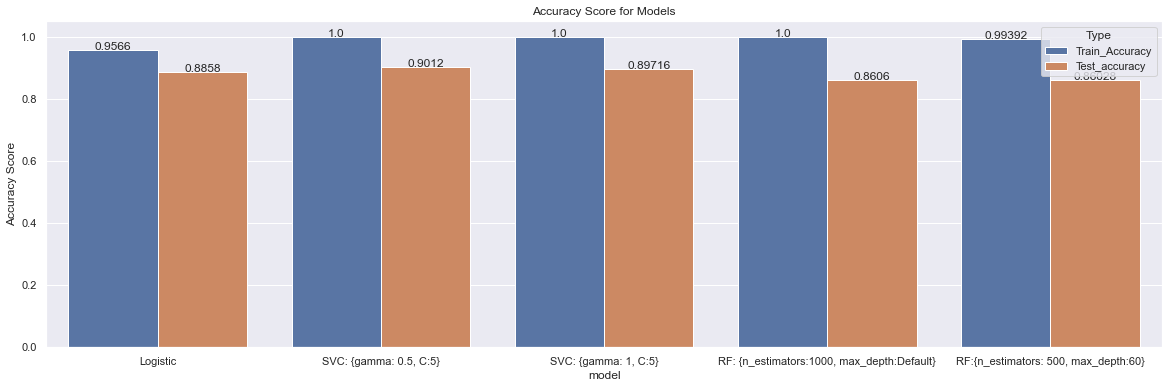

In [31]:

# Reshaping dataframe in  way to make it compatible to pass it to seaborn
df = pd.melt(report, id_vars=["model","TFIDF"], var_name="Type", value_name="Accuracy Score")

# As no significant difference noticed for min_df = 10 (only Logistic Regression improved), keeping only default setting of TFIDF
model_plot(df[df.TFIDF == 'Default'])

Advantages: Simple to build, easy to run (computationaly less expensive except maybe SVC), can capture high dimensional relationship betweeen features to predict the target class. Quick and easy to deploy until accuracy benchmark standard are not very high.
Disadvantges: They lack the capability to capture semantics and word reprentation like we do in natural language. The models at best are trying to build complex coorelation relationship which can lead to better prediction. Though the task at hand is simple, however if we were to make it more complicated like divide the reviews on more than 2 classes then these models can drift away (this is just anticipation), as they lack capability to capture the underlying formal semantic representation of words.

Takeaway: These models are good to deploy and use as starting point, however with problem becoming more complicated (sequence predcition, spell check etc) they might not be suited. Further the models have limitation to adapt to different language, for Example: if we were to use these models for non-english language then they need to be trained from scratch, further even if we change the problem by marginal like giving the ordinal rating to review, then also we cannot these models but need to build something from scratch.